# Resume NLP Project

This notebook demonstrates a basic NLP pipeline for:
1. Parsing job postings (HTML files)
2. Extracting relevant text tokens
3. Filtering out irrelevant postings
4. Clustering job postings with K-Means (and optionally Agglomerative Clustering)
5. Creating word clouds for each cluster
6. Comparing clustered skills to the skills listed in `resume.txt`

### 1. Setup and Text Preprocessing
First, we import our libraries, download necessary NLTK resources, and create text cleaning functions.
We include a version using lemmatization (you can also try stemming by using the alternative function).

In [1]:
import os
import re
import string

import pandas as pd
import numpy as np

from bs4 import BeautifulSoup

import nltk
from nltk import download
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans

from wordcloud import WordCloud

# Uncomment if you haven't downloaded NLTK stopwords
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
# Keep 'r' in case we want to preserve R as a skill
if 'r' in stop_words:
    stop_words.remove('r')
    
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["figure.dpi"] = 100

In [2]:
# Define a function to clean text:
def clean_text(text):
    """
    Lowercases text, removes punctuation, tokenizes, removes stopwords, and lemmatizes the tokens.
    """
    text = text.lower()
    text = re.sub('['+string.punctuation+']', ' ', text)
    tokens = nltk.word_tokenize(text)
    filtered = [w for w in tokens if w not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(w) for w in filtered]
    return " ".join(lemmatized)

# Optional: stemming alternative (if you wish to experiment)
def clean_text_stem(text):
    """
    Lowercases text, removes punctuation, tokenizes, removes stopwords, and stems the tokens.
    """
    text = text.lower()
    text = re.sub('['+string.punctuation+']', ' ', text)
    tokens = nltk.word_tokenize(text)
    filtered = [w for w in tokens if w not in stopwords.words('english')]
    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(w) for w in filtered]
    return " ".join(stemmed)

In [3]:
# Define the directory containing the job posting HTML files
job_postings_dir = "./data/job_postings"

# Prepare a list to store the file name and its parsed text
records = []

# Loop over each file in the job_postings directory
for file_name in os.listdir(job_postings_dir):
    if file_name.endswith(".html"):
        file_path = os.path.join(job_postings_dir, file_name)
        with open(file_path, 'r', encoding='utf-8') as f:
            html_content = f.read()

            # Parse HTML with BeautifulSoup
            soup = BeautifulSoup(html_content, 'html.parser')

            # Extract text from the HTML
            parsed_text = soup.get_text(separator=' ', strip=True)

            # Store results
            records.append({
                "filename": file_name,
                "parsed_text": parsed_text
            })

# Create a pandas DataFrame from the records
df_jobs = pd.DataFrame(records, columns=["filename", "parsed_text"])

# Display the first few rows of the DataFrame
df_jobs.head()

,filename,parsed_text
0,fb17842d02292e83.html,"Python Systems Engineer - San Francisco, CA 94..."
1,06e2c7659a3199e9.html,Santa Clara 4-H Community Ed Specialist 3 - Oa...
2,c49bf5a9b76b6943.html,Senior Software Airworthiness Engineer (2019-0...
3,0c569e6055392385.html,"Data Center Technician - Hayward, CA Data Cent..."
4,0a22c5c79af5fcf8.html,"Data Architect - Raleigh, NC 27609 Data Archit..."


In [4]:
df_jobs.shape

(1458, 2)

In [5]:
# Step 1: Read resume.txt
with open("./data/resume.txt", "r", encoding="utf-8") as f:
    resume_text = f.read()
    
print("Resume loaded. Characters in resume:", len(resume_text))

Resume loaded. Characters in resume: 683


In [6]:
resume_text

'Experience\n\n1. Developed probability simulations using NumPy.\n2. Assessed online ad-clicks for statistical significance using Permutation testing.\n3. Analyzed disease outbreaks using common clustering algorithms.\n\nAdditional Skills\n\n1. Data visualization using Matplotlib.\n2. Statistical analysis using SciPy.\n3. Processing structured tables using Pandas.\n4. Executing K-Means clustering and DBSCAN clustering using Scikit-Learn.\n5. Extracting locations from text using GeonamesCache.\n6. Location analysis and visualization using GeonamesCache and Basemap.\n7. Dimensionality reduction with PCA and SVD, using Scikit-Learn.\n8. NLP analysis and text topic detection using Scikit-Learn.'

In [7]:
# Assume you have a DataFrame of job posts and the resume in a variable:
# e.g., your DataFrame is called `df` with the job posts in a column 'job_post'
# and your resume text is in the variable `resume_text`.
#
# Here we create a new column in the DataFrame with cleaned job post text:
df_jobs['cleaned'] = df_jobs['parsed_text'].apply(clean_text)

# Similarly, clean the resume text
resume_clean = clean_text(resume_text)

df_jobs.sample(5)

,filename,parsed_text,cleaned
826,2ac183413e3f4e3d.html,"Financial Representative - Sacramento, CA 9581...",financial representative sacramento ca 95819 f...
338,9127e183e6b2e719.html,Unmanned Carrier Aviation (UCA) (55-8009) - Sa...,unmanned carrier aviation uca 55 8009 san dieg...
1295,1661aa9d550a0fbf.html,"Data Scientist 2 or 3 - McLean, VA Data Scient...",data scientist 2 3 mclean va data scientist 2 ...
1387,47d58ebb9c6574fe.html,Sr. Actuarial Consultant - Reserving Analytics...,sr actuarial consultant reserving analytics no...
1023,890e79dd572e47d9.html,"Lead Engineer, ATE Test and Characterization -...",lead engineer ate test characterization sunnyv...


In [8]:
resume_clean

'experience 1 developed probability simulation using numpy 2 assessed online ad click statistical significance using permutation testing 3 analyzed disease outbreak using common clustering algorithm additional skill 1 data visualization using matplotlib 2 statistical analysis using scipy 3 processing structured table using panda 4 executing k mean clustering dbscan clustering using scikit learn 5 extracting location text using geonamescache 6 location analysis visualization using geonamescache basemap 7 dimensionality reduction pca svd using scikit learn 8 nlp analysis text topic detection using scikit learn'

### 2. Filtering Job Posts by Resume Relevance
Next, we vectorize both the job posts and your resume using TF-IDF, compute the cosine similarity,
and filter out those postings which are below a certain similarity threshold.

In [9]:
# Initialize the TF-IDF vectorizer and compute vectors for job posts and the resume
vectorizer = TfidfVectorizer()
job_post_vectors = vectorizer.fit_transform(df_jobs['cleaned'])
resume_vector = vectorizer.transform([resume_clean])

# Compute cosine similarity between the resume and each job post
similarities = cosine_similarity(job_post_vectors, resume_vector).flatten()
df_jobs['similarity'] = similarities

# Define a threshold below which the job post is considered unrelated
threshold = 0.01 # You may need to adjust this based on your data
df_relevant = df_jobs[df_jobs['similarity'] >= threshold].copy()
print(f"Filtered down to {len(df_relevant)} relevant job posts based on resume similarity.")

Filtered down to 1337 relevant job posts based on resume similarity.


### 3. Clustering into Technical vs. Non-Technical Jobs
 
We use KMeans to cluster the relevant job posts into two clusters.
One approach to decide which cluster represents technical jobs is to analyze
the frequency of known technical keywords in each cluster.

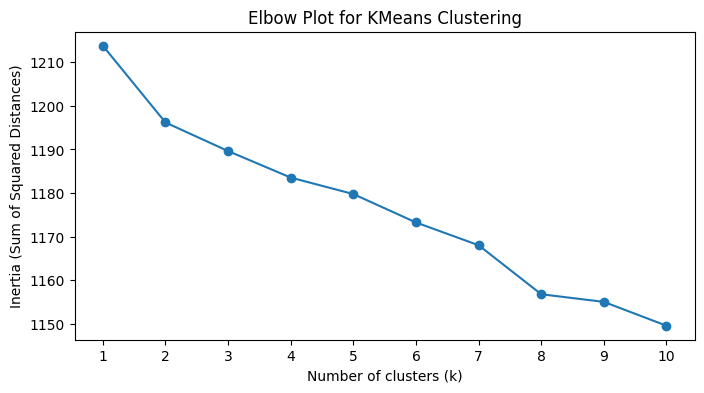

In [10]:
# Compute the TF-IDF vectors for the relevant job posts
relevant_vectors = vectorizer.transform(df_relevant['cleaned'])

# Compute inertia for a range of clusters
inertias = []
ks = range(1, 11)  # testing from 1 to 10 clusters
for k in ks:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    kmeans_temp.fit(relevant_vectors)
    inertias.append(kmeans_temp.inertia_)

# Plot the elbow plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(ks, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Plot for KMeans Clustering')
plt.xticks(ks)
plt.show()

In [11]:
# Cluster using only the relevant (and cleaned) job posts:
# Note: We use the TF-IDF vectors corresponding to the relevant posts.
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(job_post_vectors[df_jobs.index.isin(df_relevant.index)])
df_relevant['cluster'] = clusters

# %%
# Define a set of technical keywords that help identify technical job postings
technical_keywords = {
    "python", "java", "c++", "sql", "aws", "docker", "linux", 
    "cloud", "javascript", "developer", "engineering", "full", 
    "stack", "machine", "learning", "data", "software"
}

def count_technical_words(text):
    # Count how many technical keywords appear in the text.
    words = set(text.split())
    return len(technical_keywords.intersection(words))

# Evaluate the clusters by summing technical keyword counts
cluster_scores = {}
for cluster_label in df_relevant['cluster'].unique():
    cluster_text = " ".join(df_relevant[df_relevant['cluster'] == cluster_label]['cleaned'])
    score = count_technical_words(cluster_text)
    cluster_scores[cluster_label] = score

print("Technical keyword counts per cluster:", cluster_scores)

# The cluster with the higher score is likely technical.
technical_cluster = max(cluster_scores, key=cluster_scores.get)
df_technical = df_relevant[df_relevant['cluster'] == technical_cluster].copy()
print(f"Cluster {technical_cluster} identified as technical job posts.")

Technical keyword counts per cluster: {0: 16, 1: 16}
Cluster 0 identified as technical job posts.


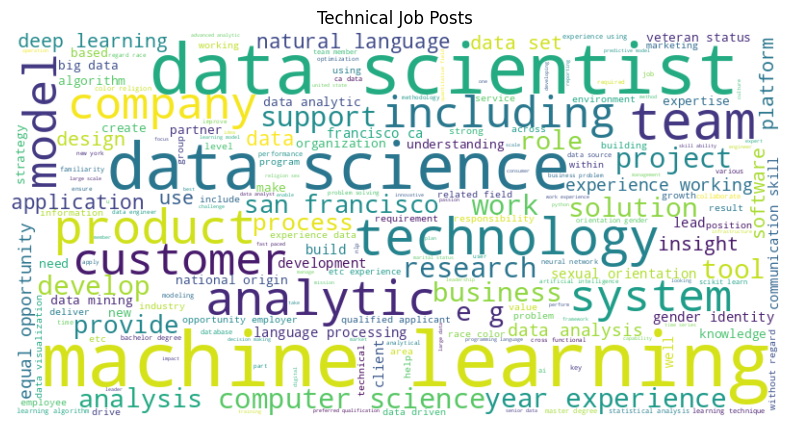

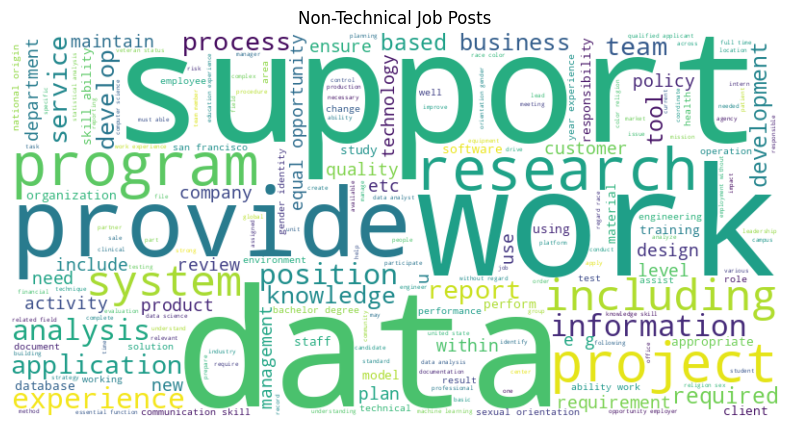

In [12]:
# Get unique cluster labels
clusters_unique = df_relevant['cluster'].unique()

# Generate a word cloud for each cluster
for cluster_label in clusters_unique:
    # Concatenate the cleaned text for all job posts in this cluster
    cluster_text = " ".join(df_relevant[df_relevant['cluster'] == cluster_label]['cleaned'])
    
    # Generate word cloud
    wc = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    
    # Define the title based on the identified technical cluster
    title = "Technical Job Posts" if cluster_label == technical_cluster else "Non-Technical Job Posts"
    plt.title(title)
    plt.show()

### 4. Recommend Top Jobs Matching the Resume
 
Here we rank the job posts within the technical cluster by similarity to your resume,
and display the top candidates.

In [13]:
df_technical.columns

Index(['filename', 'parsed_text', 'cleaned', 'similarity', 'cluster'], dtype='object')

In [14]:
# Sort technical jobs by descending similarity and take the top 5
top_jobs = df_technical.sort_values(by='similarity', ascending=False).head(5)
print("Top job matches based on resume similarity:")
print(top_jobs[['cleaned', 'similarity']].to_string(index=False))

Top job matches based on resume similarity:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

### 5. Suggest Additional Keywords for the Resume

Finally, we extract frequently occurring words from the top technical job postings.
We compare these words to those already in the resume and suggest keywords that are missing.
You can use these suggestions to modify your resume to better match desired roles.

In [15]:
# Concatenate the cleaned text of the top technical jobs
top_jobs_text = " ".join(top_jobs['cleaned'])

# Compute word frequencies from the top jobs
word_freq = pd.Series(top_jobs_text.split()).value_counts()

# Identify words in your resume
resume_words = set(resume_clean.split())

# Filter out words that already appear in your resume; you may also filter out very short words
suggested_words = word_freq[~word_freq.index.isin(resume_words)]
suggested_words = suggested_words[suggested_words.index.str.len() > 1]

# Select the top 10 suggested keywords (or adjust the number as needed)
top_suggestions = suggested_words.head(10)
print("Suggested additional keywords to consider adding to your resume:")
print(top_suggestions.to_string())

Suggested additional keywords to consider adding to your resume:
etc          30
model        28
technique    23
set          19
scientist    18
tool         17
business     17
learning     16
knowledge    16
large        15


### Additional Considerations
#### 7. Extracting Skill Sets and Finding the Optimal k (k between 8 and 15)

In [16]:
import re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import os
from bs4 import BeautifulSoup
import pandas as pd

# Define the directory containing the job posting HTML files
job_postings_dir = "./data/job_postings"

# Prepare a list to store the file name and its extracted <li> text
records = []

# Loop over each file in the job_postings directory
for file_name in os.listdir(job_postings_dir):
    if file_name.endswith(".html"):
        file_path = os.path.join(job_postings_dir, file_name)
        with open(file_path, 'r', encoding='utf-8') as f:
            html_content = f.read()
            soup = BeautifulSoup(html_content, 'html.parser')
            
            # Extract all <li> elements and join their text content
            li_elements = soup.find_all("li")
            # Join the text from each <li> into a single string
            li_text = " ".join(li.get_text(separator=" ", strip=True) for li in li_elements)
            
            records.append({
                "filename": file_name,
                "li_text": li_text
            })

# Create a pandas DataFrame from the records
df_jobs = pd.DataFrame(records, columns=["filename", "li_text"])

# Display the first few rows of the DataFrame
df_jobs.head()

,filename,li_text
0,fb17842d02292e83.html,"Indexing, understanding, and normalizing messy..."
1,06e2c7659a3199e9.html,
2,c49bf5a9b76b6943.html,Review Software requirements and associated do...
3,0c569e6055392385.html,Must be at least 18 years old High School dipl...
4,0a22c5c79af5fcf8.html,"Perform the necessary facilitation, analysis a..."


In [17]:
# Create a custom list of stop words (convert the set from stopwords.words into a list)
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
custom_stop_words = list(stopwords.words('english'))

# Vectorize the skills text using the custom stop words.
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words=custom_stop_words)
skills_tfidf = vectorizer.fit_transform(df_jobs['li_text'])

# Iterate through different values of k (from 8 to 15) to determine the optimal clustering based on silhouette scores.
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

best_k = None
best_score = -1
silhouette_scores = {}

for k in range(8, 16):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(skills_tfidf)
    score = silhouette_score(skills_tfidf, cluster_labels)
    silhouette_scores[k] = score
    print(f"For k={k}, Silhouette Score: {score:.4f}")
    if score > best_score:
        best_score = score
        best_k = k

print("\nOptimal number of clusters (k):", best_k, "with a silhouette score of:", best_score)


[nltk_data] Downloading package stopwords to /home/oem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


For k=8, Silhouette Score: 0.0021
For k=9, Silhouette Score: 0.0061
For k=10, Silhouette Score: 0.0094
For k=11, Silhouette Score: 0.0101
For k=12, Silhouette Score: 0.0107
For k=13, Silhouette Score: 0.0120
For k=14, Silhouette Score: 0.0118
For k=15, Silhouette Score: 0.0118

Optimal number of clusters (k): 13 with a silhouette score of: 0.011968249093612856


In [18]:
# Cluster using k=15 and assign cluster labels
k = 15
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(skills_tfidf)
df_jobs['cluster'] = clusters

# Optionally, print the overall silhouette score for k=15:
score_k15 = silhouette_score(skills_tfidf, clusters)
print("\nSilhouette Score for k=15:", score_k15)


# For each of the 15 clusters, determine the top skills based on average TF-IDF weights
feature_names = vectorizer.get_feature_names_out()
n_top = 10  # Number of top skills to display per cluster

print("\nTop skills by cluster:")
for cluster_num in range(k):
    # Get the indices of documents in this cluster
    indices = np.where(clusters == cluster_num)[0]
    if len(indices) == 0:
        print(f"Cluster {cluster_num} has no documents.")
        continue

    # Compute the average TF-IDF score for each term in this cluster
    cluster_tfidf = skills_tfidf[indices].toarray()
    cluster_tfidf_mean = np.mean(cluster_tfidf, axis=0)
    
    # Get indices of terms with the highest average TF-IDF scores
    top_indices = cluster_tfidf_mean.argsort()[::-1][:n_top]
    top_skills = [feature_names[i] for i in top_indices]
    print(f"Cluster {cluster_num} top skills: {top_skills}")


Silhouette Score for k=15: 0.011787534843154705

Top skills by cluster:
Cluster 0 top skills: ['students', '60', 'subjects', 'submission', 'love', 'wyzant', 'tutors', 'tutor', 'hours', 'set']
Cluster 1 top skills: ['group', 'data', 'scientific', 'tae', 'distil', 'iterating', 'convert', 'central', 'aid', 'familiarity']
Cluster 2 top skills: ['mining', 'predictive', 'experience', 'dimension', 'analytical', 'client', 'ideally', 'methods', 'reduction', 'data']
Cluster 3 top skills: ['consulting', 'designs', 'analytical', 'develops', 'databases', 'preferred', 'may', 'project', 'experience', 'sponsors']
Cluster 4 top skills: ['data', 'health', 'automation', 'aha', 'solutions', 'analytics', 'transformation', 'business', '10', 'ai']
Cluster 5 top skills: ['analysis', 'data', 'statistical', 'forecasting', 'methods', 'experience', 'quantitative', 'google', 'presentations', 'advocating']
Cluster 6 top skills: ['data', 'experience', 'learning', 'analysis', 'business', 'ability', 'machine', 'work'

### 2. Using Topic Modeling Instead of KMeans for Clustering

In [19]:
from sklearn.decomposition import LatentDirichletAllocation

# You can choose the number of topics (n_topics). One option is to use the best k found above,
# or experiment with a different number if it makes sense for your domain.
n_topics = best_k  # or set manually, e.g., n_topics = 10

lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_topics = lda.fit_transform(skills_tfidf)

# Function to display the top words for each topic for interpretability.
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        print(f"Topic {topic_idx + 1}: {' '.join(top_words)}\n")

no_top_words = 10
feature_names = vectorizer.get_feature_names_out()
display_topics(lda, feature_names, no_top_words)


Topic 1: delegating pet specimens lenders log als recommender rsm pc personalized

Topic 2: data learning experience etc machine ml aws like intelligence algorithms

Topic 3: hockey water seattle invest repair deeply roche credentialing optics ansible

Topic 4: trading genomics aiml cellular molecular phases unity d3js mass netp

Topic 5: privacy insightful throughput news documenting solr ingestion legislative regulatory commerce

Topic 6: break biology wolfram parser 30pm mon watson individually lectures rails

Topic 7: data experience analysis business learning ability work skills science machine

Topic 8: registration instabase msl vto matrix mass undergrad molecule medically bus

Topic 9: weather speed branded empower powershell sigint games angularjs lethal parental

Topic 10: routines sponsors mvs labor tso theories tpmg useful enhances generates

Topic 11: valuation acl icml fraud multimodal gaap cvpr touch tenpoint7 neurips

Topic 12: walmart environmental regulations hotel pr

### 3. Dimensionality Reduction Using Truncated SVD or PCA

Truncated SVD

In [21]:
from sklearn.decomposition import TruncatedSVD

# Choose a number of components (this is a parameter you can adjust).
n_components = 50
svd = TruncatedSVD(n_components=n_components, random_state=42)
tfidf_reduced_svd = svd.fit_transform(skills_tfidf)

print("Shape after Truncated SVD reduction:", tfidf_reduced_svd.shape)

# Determine the optimal number of clusters (k between 8 and 15) using silhouette scores
sil_scores_svd = {}
for k in range(8, 16):
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    cluster_labels_temp = kmeans_temp.fit_predict(tfidf_reduced_svd)
    score = silhouette_score(tfidf_reduced_svd, cluster_labels_temp)
    sil_scores_svd[k] = score
    print(f"TruncatedSVD: k={k}, Silhouette Score: {score:.4f}")

best_k_svd = max(sil_scores_svd, key=sil_scores_svd.get)
print(f"\nOptimal k (TruncatedSVD): {best_k_svd} with silhouette score {sil_scores_svd[best_k_svd]:.4f}")

# ----
# Cluster the reduced data using the optimal number of clusters
kmeans_svd = KMeans(n_clusters=best_k_svd, random_state=42)
clusters_svd = kmeans_svd.fit_predict(tfidf_reduced_svd)
df_jobs['cluster_svd'] = clusters_svd

# ----
# Extract the top keywords for each cluster using the original TF-IDF features
feature_names = vectorizer.get_feature_names_out()
n_top = 10  # number of top keywords per cluster

print("\nTop skills/keywords per cluster (TruncatedSVD):")
for cluster in range(best_k_svd):
    indices = np.where(df_jobs['cluster_svd'] == cluster)[0]
    if len(indices) == 0:
        print(f"Cluster {cluster} has no documents.")
        continue

    # Get the original TF-IDF values for the documents in this cluster
    cluster_tfidf = skills_tfidf[indices].toarray()
    avg_tfidf = np.mean(cluster_tfidf, axis=0)
    
    top_indices = avg_tfidf.argsort()[::-1][:n_top]
    top_keywords = [feature_names[i] for i in top_indices]
    print(f"Cluster {cluster}: {top_keywords}")

Shape after Truncated SVD reduction: (1458, 50)
TruncatedSVD: k=8, Silhouette Score: 0.1000
TruncatedSVD: k=9, Silhouette Score: 0.0873
TruncatedSVD: k=10, Silhouette Score: 0.0827
TruncatedSVD: k=11, Silhouette Score: 0.0867
TruncatedSVD: k=12, Silhouette Score: 0.0810
TruncatedSVD: k=13, Silhouette Score: 0.0840
TruncatedSVD: k=14, Silhouette Score: 0.0903
TruncatedSVD: k=15, Silhouette Score: 0.0797

Optimal k (TruncatedSVD): 8 with silhouette score 0.1000

Top skills/keywords per cluster (TruncatedSVD):
Cluster 0: ['patient', 'statement', 'teaching', 'intelligence', 'students', 'targeting', 'diversity', 'care', 'optional', 'class']
Cluster 1: ['data', 'experience', 'business', 'analysis', 'statistical', 'learning', 'science', 'etc', 'analytics', 'machine']
Cluster 2: ['experience', 'software', 'data', 'systems', 'engineering', 'development', 'design', 'system', 'security', 'years']
Cluster 3: ['consulting', 'designs', 'analytical', 'develops', 'databases', 'preferred', 'may', 'proj

In [22]:
from sklearn.decomposition import PCA

# Convert sparse TF-IDF matrix to dense for PCA
tfidf_dense = skills_tfidf.toarray()

# ----
# Dimensionality Reduction with PCA
n_components = 50  # adjust as needed
pca = PCA(n_components=n_components, random_state=42)
tfidf_reduced_pca = pca.fit_transform(tfidf_dense)

# ----
# Determine the optimal number of clusters (k between 8 and 15) using silhouette scores
sil_scores_pca = {}
for k in range(8, 16):
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    cluster_labels_temp = kmeans_temp.fit_predict(tfidf_reduced_pca)
    score = silhouette_score(tfidf_reduced_pca, cluster_labels_temp)
    sil_scores_pca[k] = score
    print(f"PCA: k={k}, Silhouette Score: {score:.4f}")

best_k_pca = max(sil_scores_pca, key=sil_scores_pca.get)
print(f"\nOptimal k (PCA): {best_k_pca} with silhouette score {sil_scores_pca[best_k_pca]:.4f}")

# ----
# Cluster the reduced data using the optimal k
kmeans_pca = KMeans(n_clusters=best_k_pca, random_state=42)
clusters_pca = kmeans_pca.fit_predict(tfidf_reduced_pca)
df_jobs['cluster_pca'] = clusters_pca

# ----
# Extract the top keywords for each cluster using the original TF-IDF features
print("\nTop skills/keywords per cluster (PCA):")
for cluster in range(best_k_pca):
    indices = np.where(df_jobs['cluster_pca'] == cluster)[0]
    if len(indices) == 0:
        print(f"Cluster {cluster} has no documents.")
        continue

    cluster_tfidf = skills_tfidf[indices].toarray()
    avg_tfidf = np.mean(cluster_tfidf, axis=0)
    
    top_indices = avg_tfidf.argsort()[::-1][:n_top]
    top_keywords = [feature_names[i] for i in top_indices]
    print(f"Cluster {cluster}: {top_keywords}")

PCA: k=8, Silhouette Score: 0.0929
PCA: k=9, Silhouette Score: 0.0859
PCA: k=10, Silhouette Score: 0.0925
PCA: k=11, Silhouette Score: 0.1010
PCA: k=12, Silhouette Score: 0.1051
PCA: k=13, Silhouette Score: 0.1093
PCA: k=14, Silhouette Score: 0.1168
PCA: k=15, Silhouette Score: 0.1182

Optimal k (PCA): 15 with silhouette score 0.1182

Top skills/keywords per cluster (PCA):
Cluster 0: ['statement', 'teaching', 'students', 'diversity', 'optional', 'class', 'contributions', 'research', 'student', 'instructor']
Cluster 1: ['experience', 'data', 'software', 'design', 'development', 'systems', 'analysis', 'work', 'python', 'engineering']
Cluster 2: ['data', 'experience', 'business', 'analysis', 'statistical', 'learning', 'etc', 'analytics', 'models', 'techniques']
Cluster 3: ['consulting', 'designs', 'analytical', 'develops', 'databases', 'preferred', 'may', 'project', 'experience', 'sponsors']
Cluster 4: ['must', 'position', 'service', 'education', 'submit', 'may', 'resume', 'federal', 'pre